<h1>Independent socioeconomic, structural, and clinical predictors of mortality.</h1>

In [1]:
# --- Load Required Libraries ---
suppressPackageStartupMessages({
# Data Wrangling and Preparation
library(dplyr)      # Data manipulation, filtering, and subsetting (N=4,602 to n=3,464)
library(lubridate)  # Date-time processing for survival time (Overall Survival) calculations
library(stringr)    # String manipulation for cleaning histological and educational labels

# Survival Analysis Core
library(survival)   # Core functions for Kaplan-Meier estimates and Cox Proportional Hazards models

# Statistical Reporting and Diagnostics
library(gtsummary)  # Publication-quality summary tables and regression model reporting
library(car)        # Regression diagnostics, including Variance Inflation Factor (VIF) checks

# Publication-Ready Table Export
library(flextable)  # Advanced table formatting for manuscript-ready outputs
library(officer)    # Automated Word (.docx) document generation and table integration

# Data Visualization
library(ggplot2)    # Construction of the multivariable Forest Plot (Figure 2)
    })

Warning message:
“package ‘car’ was built under R version 4.3.3”
Warning message:
“package ‘carData’ was built under R version 4.3.3”
Warning message:
“package ‘flextable’ was built under R version 4.3.3”
Warning message:
“package ‘officer’ was built under R version 4.3.3”


<h2>Section 1: Data Preparation</h2>

In [2]:
# 1. Load Data
# Ensure your CSV has columns like: 'age', 'sex', 'year_diag'
raw_data <- read.csv("data/data.csv")

In [3]:
names(raw_data)

[1] "X"                   "Sexo"                "Fecha_nac"          
 [4] "Anio_nac"            "Parr_res"            "Cant_res"           
 [7] "Activ_laboral"       "Nivel_educ"          "Establecimiento"    
[10] "Fecha_fall"          "Anio_fall"           "Fecha_diag"         
[13] "Anio_diag"           "Base_diag"           "Morf_tumor_CIEO3"   
[16] "Localiz_tumor_r"     "Fecha_ultcont"       "Anio_ultcont"       
[19] "Estado_vital"        "Num_tumores"         "Diferenc_tumor"     
[22] "Tipo_cancer_CIEO3_r" "Tipo_cancer_CIE10_r" "Nivins"             
[25] "Profesion"

In [4]:
# --- DATA PREPARATION AND TRANSLATION ---
# Ensure required libraries are loaded


study_data <- raw_data %>%
  # 1. Temporal and Age Filtering
  # Filter for the study period (1996-2019) and adults (>=18)
  mutate(Age = Anio_diag - Anio_nac) %>%
  filter(Anio_diag >= 1996 & Anio_diag <= 2019) %>%
  filter(Age >= 18) %>%
  
  # 2. Demographic Translation
  # Sex: Hombre -> Male, Mujer -> Female
  mutate(Sex = factor(Sexo, levels = c("Mujer", "Hombre"), labels = c("Female", "Male"))) %>%
  mutate(year_diag = Anio_diag)%>%
  
  # Education: Mapping registry levels to manuscript categories
  mutate(Education = case_when(
    Nivel_educ == "Ninguna" ~ "None / Illiterate",
    Nivel_educ == "Primaria" ~ "Primary",
    Nivel_educ == "Secundaria" ~ "Secondary",
    Nivel_educ == "Superior" ~ "Higher (University/Technical)",
    TRUE ~ "Missing/Unknown"
  )) %>%
  # Set 'Higher' as the reference group for the Cox model
  mutate(Education = factor(Education, levels = c("Higher (University/Technical)", "Secondary", "Primary", "None / Illiterate"))) %>%
  
  # 3. Health System Affiliation
  # Mapping institutional entry points
  mutate(Establishment = case_when(
    Establecimiento == "IESS" ~ "Social Security (IESS)",
    Establecimiento == "MSP" ~ "Ministry of Public Health (MSP)",
    Establecimiento == "SOLCA" ~ "Specialized Cancer Center (SOLCA)",
    Establecimiento == "Privados no SOLCA" ~ "Private Sector",
    Establecimiento == "INEC" ~ "No Health System Link (INEC)",
    TRUE ~ "Other/Missing"
  )) %>%
  # Filter out 'INEC' for survival analysis as they are DCO/No follow-up
  filter(Establishment != "No Health System Link (INEC)") %>%
  # Set 'IESS' as the reference group
  mutate(Establishment = factor(Establishment, levels = c("Social Security (IESS)", "Ministry of Public Health (MSP)", "Specialized Cancer Center (SOLCA)", "Private Sector"))) %>%
  
  # 4. Clinical Variables (Subtype and Site)
  # Subtype mapping based on CIEO3 Morphology
  mutate(Subtype = case_when(
    grepl("grandes difuso", Morf_tumor_CIEO3, ignore.case = TRUE) ~ "Diffuse Large B-Cell (DLBCL)",
    grepl("hodgkin", Morf_tumor_CIEO3, ignore.case = TRUE) ~ "Hodgkin Lymphoma",
    grepl("folicular", Morf_tumor_CIEO3, ignore.case = TRUE) ~ "Follicular Lymphoma",
    grepl("Burkitt", Morf_tumor_CIEO3, ignore.case = TRUE) ~ "Burkitt Lymphoma",
    grepl("Células T", Diferenc_tumor, ignore.case = TRUE) | grepl("NK", Diferenc_tumor, ignore.case = TRUE) ~ "Mature T/NK-Cell",
    TRUE ~ "B-Cell / NOS / Other"
  )) %>%
  mutate(Subtype = factor(Subtype, levels = c("Diffuse Large B-Cell (DLBCL)", "Follicular Lymphoma", "Hodgkin Lymphoma", "Mature T/NK-Cell", "Burkitt Lymphoma", "B-Cell / NOS / Other"))) %>%

  # Tumor Site mapping using topographic codes
  mutate(Tumor_Site = case_when(
    grepl("C77", Localiz_tumor_r) ~ "Nodal",
    grepl("C169", Localiz_tumor_r) ~ "Gastric",
    TRUE ~ "Other Extranodal"
  )) %>%
  mutate(Tumor_Site = factor(Tumor_Site, levels = c("Nodal", "Gastric", "Other Extranodal"))) %>%
  
  # 5. Survival Time and Status (OS)
  mutate(
    # Status: Fallecido = 1, Vivo = 0
    OS_status = ifelse(Estado_vital == "Fallecido", 1, 0),
    # Time: Difference between diagnosis and death (or last contact)
    date_diag = as.Date(Fecha_diag),
    date_end = as.Date(ifelse(Estado_vital == "Fallecido", 
                              as.character(Fecha_fall), 
                              as.character(Fecha_ultcont))),
    OS_time = as.numeric(difftime(date_end, date_diag, units = "days")) / 365.25
  ) %>%
  # Remove records with invalid survival times (<= 0)
  filter(!is.na(OS_time) & OS_time > 0)

# Verify the final cohort count (Should be close )
nrow(study_data)

[1] 3464

In [5]:
# 3. Create Standard 5-Year Age Brackets
# This is required to calculate Age-Specific Rates (ASR)
study_data <- study_data %>%
  mutate(age_group = cut(Age, 
                         breaks = c(18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, Inf),
                         labels = c("18-19", "20-24", "25-29", "30-34", "35-39", "40-44", 
                                    "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", 
                                    "75-79", "80-84", "85+"),
                         right = FALSE))

# 4. Aggregate Cases by Year and Age Group
# This table will be the foundation for the 2050 projection
annual_cases_age <- study_data %>%
  group_by(year_diag, age_group) %>%
  summarise(n_cases = n(), .groups = 'drop')


<h2>Section 2: COX Regression</h2>

In [6]:
# 3. RUN  COX REGRESSION
final_cox_site <- coxph(Surv(OS_time, OS_status) ~ Age + Sex + Education + Establishment + Subtype + Tumor_Site, 
                        data = study_data)



In [7]:
# 4. CREATE THE TABLE OBJECT
cox_table <- tbl_regression(final_cox_site, exponentiate = TRUE) %>%
  bold_p() %>%
  bold_labels() %>%
  add_global_p()

In [8]:
# 5. EXPORT TO HTML
cox_table %>%
  as_gt() %>%
  gt::gtsave("tables/Table_Cox_Regression.html")

In [9]:
# 6. EXPORT TO WORD
cox_table %>%
  as_flex_table() %>%
  # Professional styling for Word
  fontsize(size = 9, part = "all") %>%
  autofit() %>%
  save_as_docx(path = "tables/Table_Cox_Regression.docx")


  <style>#xcsqcbixpm table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#xcsqcbixpm thead, #xcsqcbixpm tbody, #xcsqcbixpm tfoot, #xcsqcbixpm tr, #xcsqcbixpm td, #xcsqcbixpm th {
  border-style: none;
}

#xcsqcbixpm p {
  margin: 0;
  padding: 0;
}

#xcsqcbixpm .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #A8A8A8;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
}

#xcsqcbixpm .gt_caption {
  padding-top: 4px;
  padding-bottom: 4px;
}

#xcsqcbixpm .gt_title {
  color: #333333;
  font-size: 125%;
  font-weight: initial;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-color: #FFFFFF;
  border-bottom-width: 0;
}

#xcsqcbixpm .gt_subtitle {
  color: #333333;
  font-size: 85%;
  font-weight: initial;
  padding-top: 3px;
  padding-bottom: 5px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-color: #FFFFFF;
  border-top-width: 0;
}

#xcsqcbixpm .gt_heading {
  background-color: #FFFFFF;
  text-align: center;
  border-bottom-color: #FFFFFF;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#xcsqcbixpm .gt_bottom_border {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#xcsqcbixpm .gt_col_headings {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#xcsqcbixpm .gt_col_heading {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: normal;
  text-transform: inherit;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 6px;
  padding-left: 5px;
  padding-right: 5px;
  overflow-x: hidden;
}

#xcsqcbixpm .gt_column_spanner_outer {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: normal;
  text-transform: inherit;
  padding-top: 0;
  padding-bottom: 0;
  padding-left: 4px;
  padding-right: 4px;
}

#xcsqcbixpm .gt_column_spanner_outer:first-child {
  padding-left: 0;
}

#xcsqcbixpm .gt_column_spanner_outer:last-child {
  padding-right: 0;
}

#xcsqcbixpm .gt_column_spanner {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 5px;
  overflow-x: hidden;
  display: inline-block;
  width: 100%;
}

#xcsqcbixpm .gt_spanner_row {
  border-bottom-style: hidden;
}

#xcsqcbixpm .gt_group_heading {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  text-align: left;
}

#xcsqcbixpm .gt_empty_group_heading {
  padding: 0.5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: middle;
}

#xcsqcbixpm .gt_from_md > :first-child {
  margin-top: 0;
}

#xcsqcbixpm .gt_from_md > :last-child {
  margin-bottom: 0;
}

#xcsqcbixpm .gt_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  margin: 10px;
  border-top-style: solid;
  border-top-width: 1px;
  border-top-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  overflow-x: hidden;
}

#xcsqcbixpm .gt_stub {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
}

#xcsqcbixpm .gt_stub_row_group {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
  vertical-align: top;
}

#xcsqcbixpm .gt_row_group_first td {
  border-top-width: 2px;
}

#xcsqcbixpm .gt_row_group_first th {
  border-top-width: 2px;
}

#xcsqcbixpm .gt_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#xcsqcbixpm .gt_first_summary_row {
  border-top-style: solid;
  border-top-color: #D3D3D3;
}

#xcsqcbixpm .gt_first_summary_row.thick {
  border-top-width: 2px;
}

#xcsqcbixpm .gt_last_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#xcsqcbixpm .gt_grand_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#xcsqcbixpm .gt_first_grand_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-style: double;
  border-top-width: 6px;
  border-top-color: #D3D3D3;
}

#xcsqcbixpm .gt_last_grand_summary_row_top {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: double;
  border-bottom-width: 6px;
  border-bottom-color: #D3D3D3;
}

#xcsqcbixpm .gt_striped {
  background-color: rgba(128, 128, 128, 0.05);
}

#xcsqcbixpm .gt_table_body {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#xcsqcbixpm .gt_footnotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#xcsqcbixpm .gt_footnote {
  margin: 0px;
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#xcsqcbixpm .gt_sourcenotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#xcsqcbixpm .gt_sourcenote {
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#xcsqcbixpm .gt_left {
  text-align: left;
}

#xcsqcbixpm .gt_center {
  text-align: center;
}

#xcsqcbixpm .gt_right {
  text-align: right;
  font-variant-numeric: tabular-nums;
}

#xcsqcbixpm .gt_font_normal {
  font-weight: normal;
}

#xcsqcbixpm .gt_font_bold {
  font-weight: bold;
}

#xcsqcbixpm .gt_font_italic {
  font-style: italic;
}

#xcsqcbixpm .gt_super {
  font-size: 65%;
}

#xcsqcbixpm .gt_footnote_marks {
  font-size: 75%;
  vertical-align: 0.4em;
  position: initial;
}

#xcsqcbixpm .gt_asterisk {
  font-size: 100%;
  vertical-align: 0;
}

#xcsqcbixpm .gt_indent_1 {
  text-indent: 5px;
}

#xcsqcbixpm .gt_indent_2 {
  text-indent: 10px;
}

#xcsqcbixpm .gt_indent_3 {
  text-indent: 15px;
}

#xcsqcbixpm .gt_indent_4 {
  text-indent: 20px;
}

#xcsqcbixpm .gt_indent_5 {
  text-indent: 25px;
}

#xcsqcbixpm .katex-display {
  display: inline-flex !important;
  margin-bottom: 0.75em !important;
}

#xcsqcbixpm div.Reactable > div.rt-table > div.rt-thead > div.rt-tr.rt-tr-group-header > div.rt-th-group:after {
  height: 0px !important;
}
</style>
  <table class="gt_table" data-quarto-disable-processing="false" data-quarto-bootstrap="false">
  <thead>
    <tr class="gt_col_headings">
      <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="label"><span class="gt_from_md"><strong>Characteristic</strong></span></th>
      <th class="gt_col_heading gt_columns_bottom_border gt_center" rowspan="1" colspan="1" scope="col" id="estimate"><span class="gt_from_md"><strong>HR</strong></span></th>
      <th class="gt_col_heading gt_columns_bottom_border gt_center" rowspan="1" colspan="1" scope="col" id="conf.low"><span class="gt_from_md"><strong>95% CI</strong></span></th>
      <th class="gt_col_heading gt_columns_bottom_border gt_center" rowspan="1" colspan="1" scope="col" id="p.value"><span class="gt_from_md"><strong>p-value</strong></span></th>
    </tr>
  </thead>
  <tbody class="gt_table_body">
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Age</td>
<td headers="estimate" class="gt_row gt_center">1.03</td>
<td headers="conf.low" class="gt_row gt_center">1.03, 1.03</td>
<td headers="p.value" class="gt_row gt_center" style="font-weight: bold;">&lt;0.001</td></tr>
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Sex</td>
<td headers="estimate" class="gt_row gt_center"><br></td>
<td headers="conf.low" class="gt_row gt_center"><br></td>
<td headers="p.value" class="gt_row gt_center" style="font-weight: bold;">&lt;0.001</td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Female</td>
<td headers="estimate" class="gt_row gt_center">—</td>
<td headers="conf.low" class="gt_row gt_center">—</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Male</td>
<td headers="estimate" class="gt_row gt_center">1.25</td>
<td headers="conf.low" class="gt_row gt_center">1.15, 1.36</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Education</td>
<td headers="estimate" class="gt_row gt_center"><br></td>
<td headers="conf.low" class="gt_row gt_center"><br></td>
<td headers="p.value" class="gt_row gt_center" style="font-weight: bold;">&lt;0.001</td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Higher (University/Technical)</td>
<td headers="estimate" class="gt_row gt_center">—</td>
<td headers="conf.low" class="gt_row gt_center">—</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Secondary</td>
<td headers="estimate" class="gt_row gt_center">1.27</td>
<td headers="conf.low" class="gt_row gt_center">1.12, 1.44</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Primary</td>
<td headers="estimate" class="gt_row gt_center">1.45</td>
<td headers="conf.low" class="gt_row gt_center">1.28, 1.65</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;None / Illiterate</td>
<td headers="estimate" class="gt_row gt_center">2.01</td>
<td headers="conf.low" class="gt_row gt_center">1.66, 2.44</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Establishment</td>
<td headers="estimate" class="gt_row gt_center"><br></td>
<td headers="conf.low" class="gt_row gt_center"><br></td>
<td headers="p.value" class="gt_row gt_center" style="font-weight: bold;">&lt;0.001</td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Social Security (IESS)</td>
<td headers="estimate" class="gt_row gt_center">—</td>
<td headers="conf.low" class="gt_row gt_center">—</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Ministry of Public Health (MSP)</td>
<td headers="estimate" class="gt_row gt_center">1.29</td>
<td headers="conf.low" class="gt_row gt_center">1.14, 1.46</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Specialized Cancer Center (SOLCA)</td>
<td headers="estimate" class="gt_row gt_center">0.92</td>
<td headers="conf.low" class="gt_row gt_center">0.82, 1.03</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Private Sector</td>
<td headers="estimate" class="gt_row gt_center">0.87</td>
<td headers="conf.low" class="gt_row gt_center">0.77, 0.97</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Subtype</td>
<td headers="estimate" class="gt_row gt_center"><br></td>
<td headers="conf.low" class="gt_row gt_center"><br></td>
<td headers="p.value" class="gt_row gt_center" style="font-weight: bold;">&lt;0.001</td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Diffuse Large B-Cell (DLBCL)</td>
<td headers="estimate" class="gt_row gt_center">—</td>
<td headers="conf.low" class="gt_row gt_center">—</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Follicular Lymphoma</td>
<td headers="estimate" class="gt_row gt_center">0.55</td>
<td headers="conf.low" class="gt_row gt_center">0.46, 0.65</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Hodgkin Lymphoma</td>
<td headers="estimate" class="gt_row gt_center">0.93</td>
<td headers="conf.low" class="gt_row gt_center">0.83, 1.05</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Mature T/NK-Cell</td>
<td headers="estimate" class="gt_row gt_center">1.51</td>
<td headers="conf.low" class="gt_row gt_center">1.09, 2.10</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Burkitt Lymphoma</td>
<td headers="estimate" class="gt_row gt_center">3.10</td>
<td headers="conf.low" class="gt_row gt_center">1.47, 6.54</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;B-Cell / NOS / Other</td>
<td headers="estimate" class="gt_row gt_center">0.99</td>
<td headers="conf.low" class="gt_row gt_center">0.89, 1.11</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left" style="font-weight: bold;">Tumor_Site</td>
<td headers="estimate" class="gt_row gt_center"><br></td>
<td headers="conf.low" class="gt_row gt_center"><br></td>
<td headers="p.value" class="gt_row gt_center">0.3</td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Nodal</td>
<td headers="estimate" class="gt_row gt_center">—</td>
<td headers="conf.low" class="gt_row gt_center">—</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Gastric</td>
<td headers="estimate" class="gt_row gt_center">1.11</td>
<td headers="conf.low" class="gt_row gt_center">0.96, 1.29</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
    <tr><td headers="label" class="gt_row gt_left">&nbsp;&nbsp;&nbsp;&nbsp;Other Extranodal</td>
<td headers="estimate" class="gt_row gt_center">0.95</td>
<td headers="conf.low" class="gt_row gt_center">0.83, 1.09</td>
<td headers="p.value" class="gt_row gt_center"><br></td></tr>
  </tbody>
  <tfoot>
    <tr class="gt_sourcenotes">
      <td class="gt_sourcenote" colspan="4"><span class="gt_from_md">Abbreviations: CI = Confidence Interval, HR = Hazard Ratio</span></td>
    </tr>
  </tfoot>
</table>


<h2>Section 3: Visualization and Reporting</h2>

In [10]:
# --- 7. EXTRACT & CLEAN DATA (Adding "vs Reference") ---
forest_data <- broom::tidy(final_cox_site, exponentiate = TRUE, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  mutate(
    # A. Rename columns
    HR = estimate,
    Lower = conf.low,
    Upper = conf.high,
    
    # B. Define Groups
    Variable_Group = case_when(
      str_detect(term, "Education") | str_detect(term, "Establishment") ~ "Socioeconomic & Access",
      str_detect(term, "Age") | str_detect(term, "Sex") ~ "Demographic",
      str_detect(term, "Subtype") | str_detect(term, "Tumor_Site") ~ "Clinical",
      TRUE ~ "Other"
    ),
    
    # C. Create Explicit "vs Reference" Labels
    Label = case_when(
      # Demographic
      term == "Age" ~ "Age (per year)",
      term == "SexMale" ~ "Male vs Female",
      
      # Education (Ref: Higher)
      str_detect(term, "Education") ~ paste0(str_remove(term, "Education"), " vs Higher Edu"),
      
      # Establishment (Ref: IESS) - Shorten the long MSP/SOLCA names for the plot
      str_detect(term, "Ministry of Public Health") ~ "MSP vs IESS",
      str_detect(term, "Specialized Cancer Center") ~ "SOLCA vs IESS",
      str_detect(term, "Private Sector") ~ "Private vs IESS",
      
      # Subtype (Ref: DLBCL)
      str_detect(term, "Subtype") ~ paste0(str_remove(term, "Subtype"), " vs DLBCL"),
      
      # Tumor Site (Ref: Nodal)
      str_detect(term, "Tumor_Site") ~ paste0(str_remove(term, "Tumor_Site"), " vs Nodal"),
      
      TRUE ~ term
    ),
    
    # D. Significance
    Significance = ifelse(p.value < 0.05, "Significant", "Not Significant")
  ) %>%
  mutate(
    Variable_Group = factor(Variable_Group, levels = c("Clinical", "Demographic", "Socioeconomic & Access")),
    HR_Label = paste0(sprintf("%.2f", HR), " (", sprintf("%.2f", Lower), "-", sprintf("%.2f", Upper), ")")
  )

In [11]:
# --- 8. SET EXACT ORDER (Matching your Image) ---
# Note: I updated these names to match the new "vs" labels we just created above
desired_order <- c(
  # Clinical
  "Hodgkin Lymphoma vs DLBCL", 
  "Follicular Lymphoma vs DLBCL", 
  "Mature T/NK-Cell vs DLBCL", 
  "Burkitt Lymphoma vs DLBCL", 
  "B-Cell / NOS / Other vs DLBCL", 
  "Gastric vs Nodal", 
  "Other Extranodal vs Nodal",
  
  # Demographic
  "Age (per year)", 
  "Male vs Female",
  
  # Socioeconomic & Access
  "None / Illiterate vs Higher Edu", 
  "Primary vs Higher Edu", 
  "Secondary vs Higher Edu", 
  "MSP vs IESS", 
  "SOLCA vs IESS", 
  "Private vs IESS"
)

# Apply the order
forest_data$Label <- factor(forest_data$Label, levels = rev(desired_order))

In [12]:
# --- 9. GENERATE PLOT ---
p_final <- ggplot(forest_data, aes(y = Label, x = HR, xmin = Lower, xmax = Upper, color = Significance)) +
  geom_point(size = 3.5) + 
  geom_errorbar(width = 0.2, linewidth = 0.8) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("gray50", "#E01E5A")) +
  facet_grid(Variable_Group ~ ., scales = "free_y", space = "free_y", switch = "y") +
  scale_x_log10(breaks = c(0.5, 1, 1.5, 2, 3, 4)) +
  
  labs( 
       x = "Hazard Ratio (Log Scale)", 
       y = "") +
  
  theme_minimal(base_size = 18) + 
  theme(
    plot.title.position = "plot", 
    plot.title = element_text(face = "bold", hjust = 0.5), 
    plot.subtitle = element_text(hjust = 0.5),
    strip.placement = "outside",
    strip.text.y.left = element_text(angle = 90, face = "bold", size = 14),
    strip.background = element_rect(fill = "gray95", color = "black", linewidth = 1),
    panel.grid.minor = element_blank(),
    legend.position = "bottom",
    axis.line.y = element_blank(),
    axis.ticks.y = element_blank(),
    plot.margin = margin(1, 1, 1, 1, "cm"),
    plot.background = element_rect(fill = "white", color = NA)
  ) +
  geom_text(aes(label = HR_Label), vjust = -0.7, size = 5, show.legend = FALSE, color = "black")

<h2>Section 4: Save figures</h2>

In [13]:
# --- 10. SAVE ---
ggsave("images/Figure2_Forest_Plot.png", plot = p_final, width = 13, height = 10, dpi = 600) 
print("Plot saved successfully.")

[1] "Plot saved successfully."


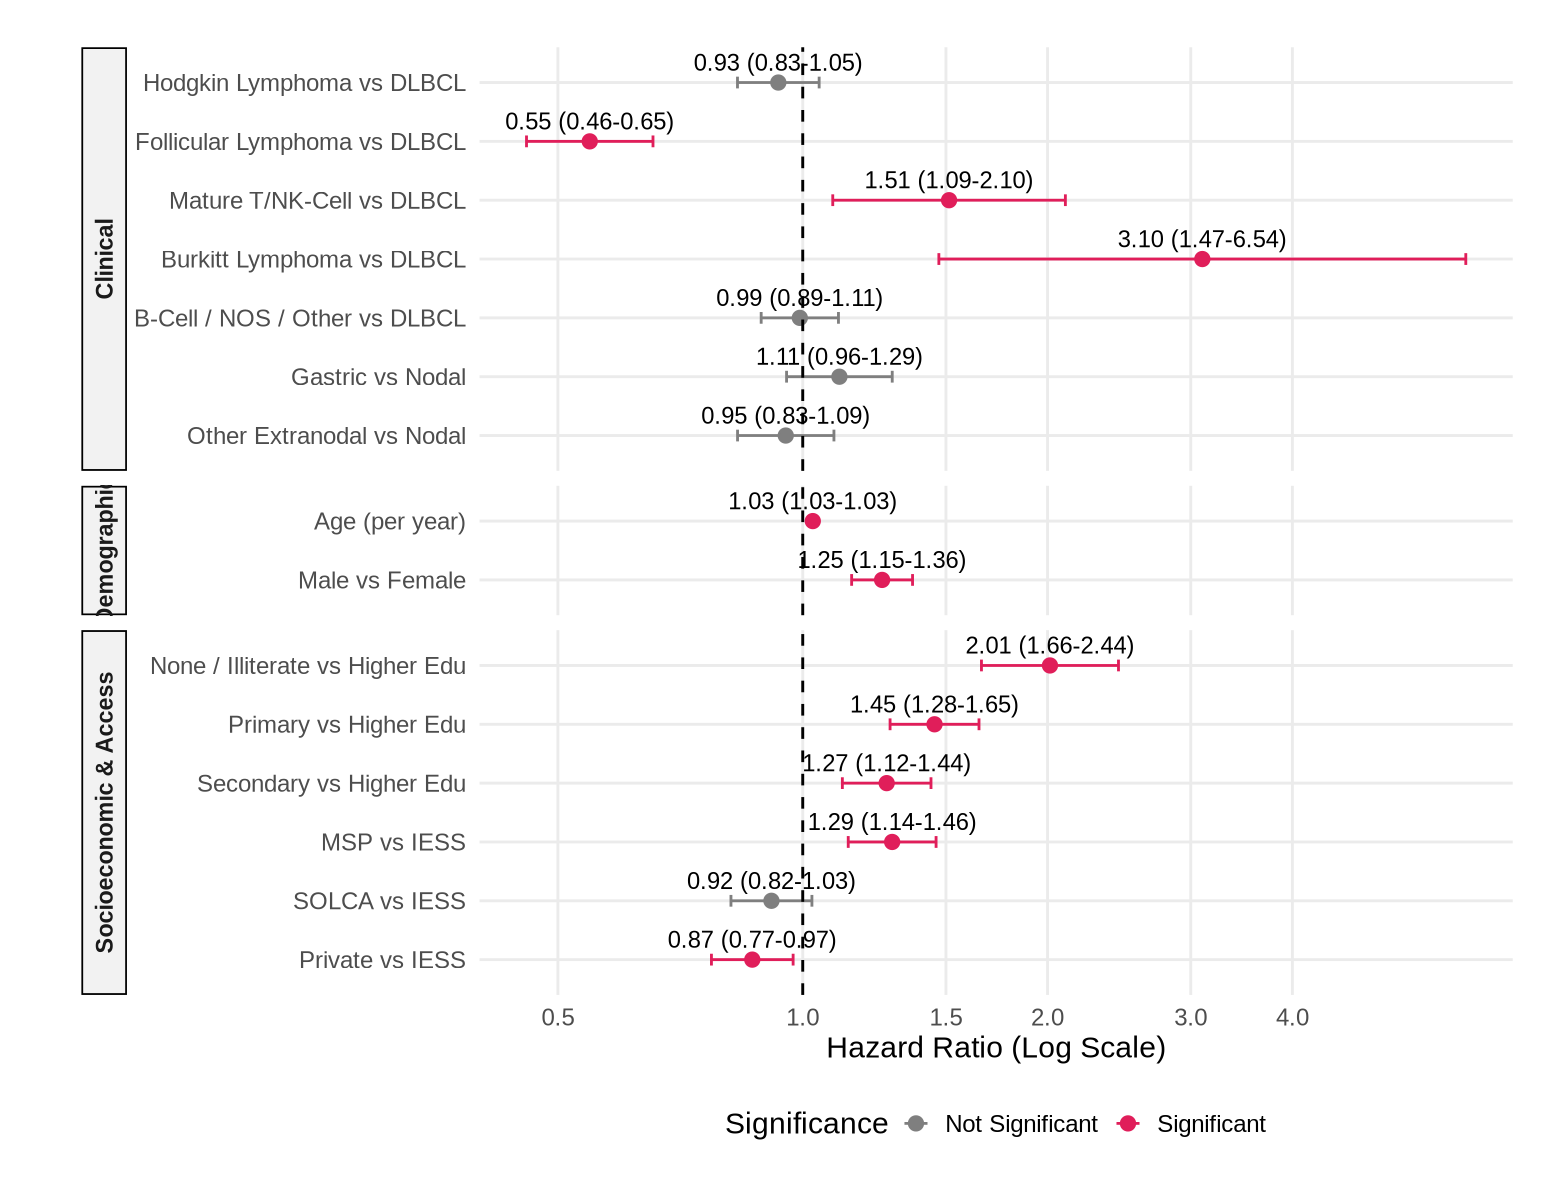

In [14]:
# print Figure

options(repr.plot.width = 13, repr.plot.height = 10, dpi = 600)

# 2. Print the variable
p_final